<a id="table"></a>
<h1 style="background-color:blue;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Description](#4)

[5. Data Exploration](#5)

[6. Baseline Modeling 1.0](#6)

[7. Baseline Modeling 2.0](#7)




In [3]:

import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklego.linear_model import LADRegression

<a id='3'></a>
# <h1 style="background-color:blue;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
original = pd.read_csv('CrabAgePrediction.csv')
submission = pd.read_csv('sample_submission.csv')

print('The dimension of the train synthetic dataset is: ', train.shape)
print('The dimension of the test synthetic dataset is: ', test.shape)
print('The dimension of the original dataset is: ', original.shape)
print('The dimension of the submission dataset is: ', submission.shape)


The dimension of the train synthetic dataset is:  (74051, 10)
The dimension of the test synthetic dataset is:  (49368, 9)
The dimension of the original dataset is:  (3893, 9)
The dimension of the submission dataset is:  (49368, 2)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [6]:
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [7]:
train.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [8]:
original.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [9]:
original.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791
std,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


<a id="4"></a>
# <h1 style="background-color:blue;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Description</h1>
This is a synthetic dataset generated from the [Crab Age Prediction](https://www.kaggle.com/datasets/sidhus/crab-age-prediction) dataset. These are the descriptions of the variables in this dataset:
<ul>
<li> Sex: Gender of the Crab - Male, Female and Indeterminate </li>
<li> Length: Length of the Crab in feet </li>
<li> Diameter: Diameter of the Crab in feet </li>
<li> Height: Height of the Crab in feet </li>
<li> Weight: Weight of the Crab in ounces </li>
<li> Shucked Weight: Weight without the shell in ounces </li>
<li> Viscera Weight: Weight that wraps around the crab's abdominal organs in ounces </li>
<li> Shell Weight: Weight of the Shell in ounces </li>
<li> Age: Age of the Crab in months</li>


<a id="5"></a>
# <h1 style="background-color:blue;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>
First we start by visualizing the variale of interest.

Text(0.5, 1.0, 'Original Dataset')

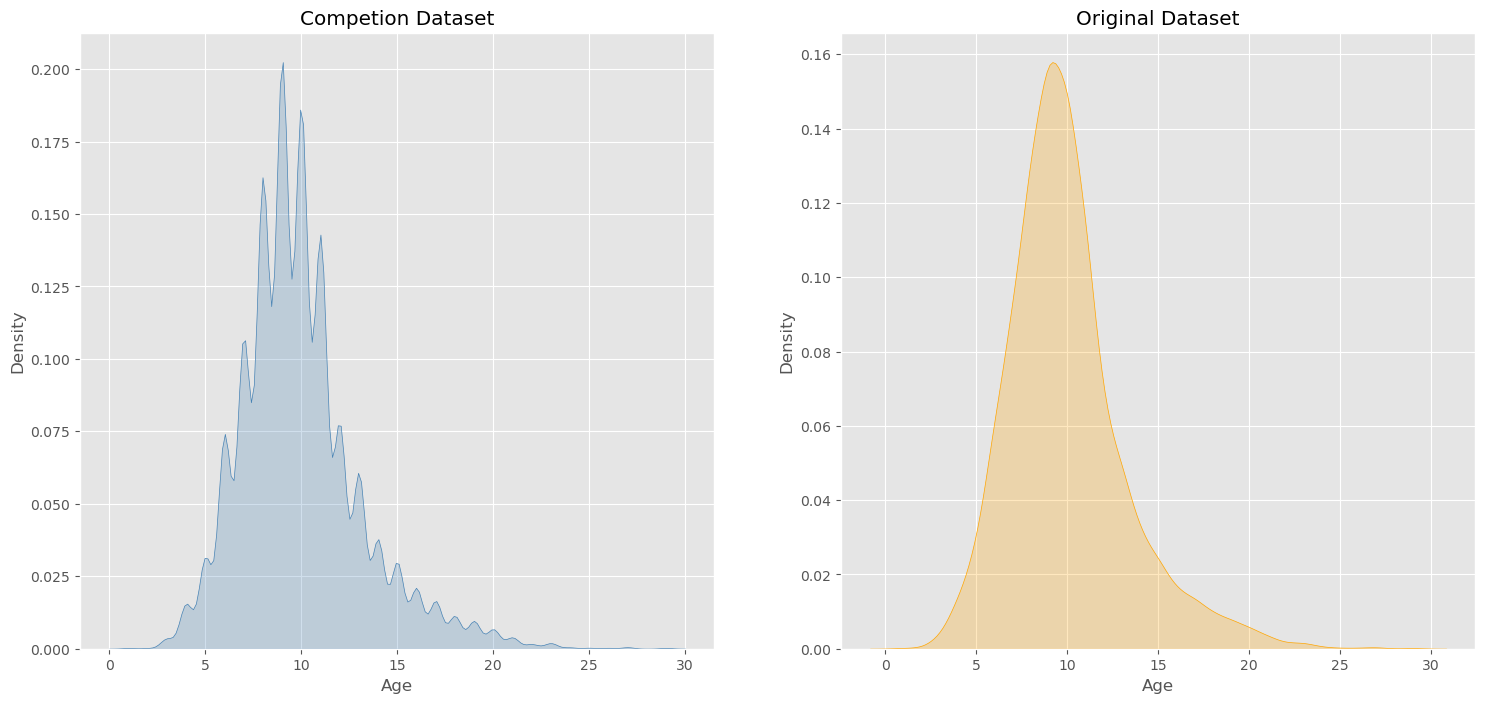

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.kdeplot(ax=axes[0], data=train, x= 'Age', fill=True, color = 'steelblue').set_title('Competion Dataset')
sns.kdeplot(ax=axes[1], data = original, x = 'Age', fill = True, color = 'orange').set_title('Original Dataset')


By the quick eye-ball test, the distribution of the variable of interest are approximately the same in the competition and orginal data set. Next, we explore what feature are related to the variable of interest.

In [11]:
original.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


Text(0.5, 1.0, 'Correlation Among Features (in Original Dataset)')

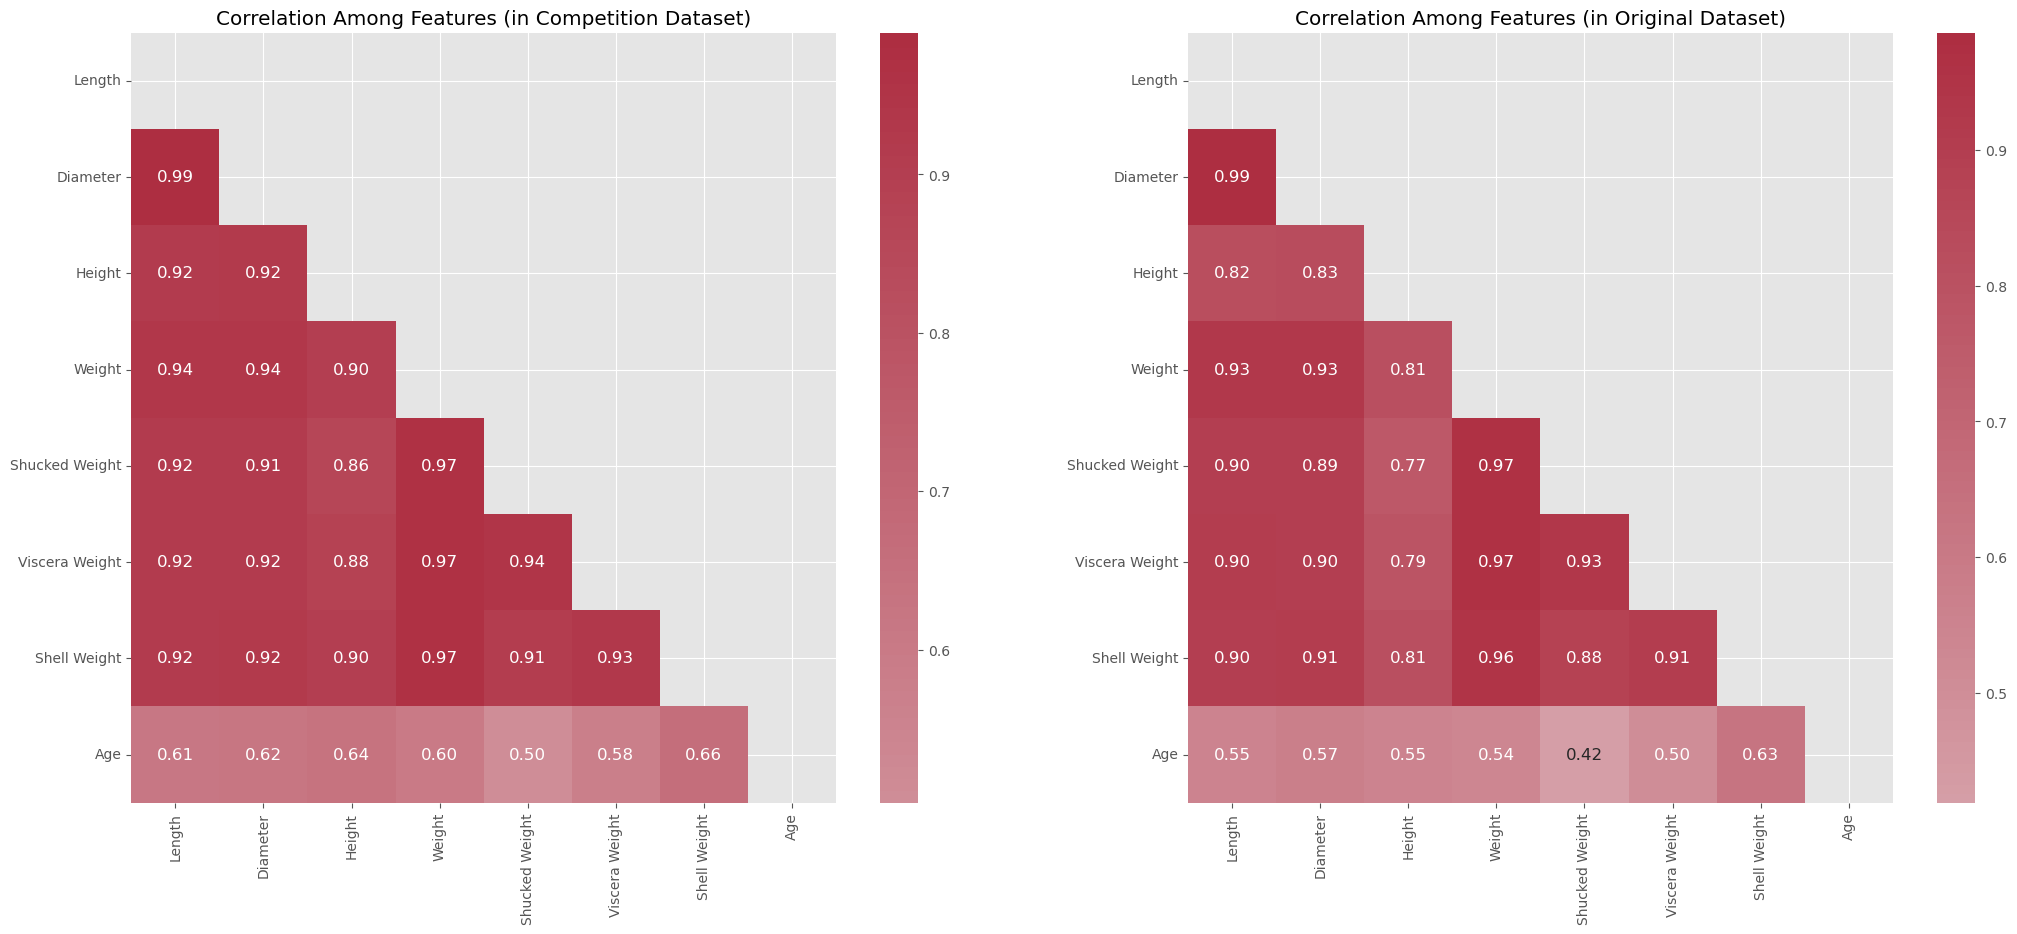

In [12]:
corr_mat_data = train.drop(columns=['id', 'Sex'], axis=1).corr()
corr_mat_original = original.drop(columns=['Sex'], axis=1).corr()

data_mask = np.triu(np.ones_like(corr_mat_data, dtype=bool))
original_mask = np.triu(np.ones_like(corr_mat_original, dtype=bool))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center='light', as_cmap=True)
fig, axes = plt.subplots(1, 2 , figsize=(25, 10))
sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt = '.2f', center = 0,
            annot_kws={'size': 12}, ax=axes[0], mask=data_mask).set_title('Correlation Among Features (in Competition Dataset)')

sns.heatmap(corr_mat_original, annot=True, cmap=cmap, fmt= '.2f', center=0, 
            annot_kws={'size': 12}, ax=axes[1], mask=original_mask).set_title('Correlation Among Features (in Original Dataset)')

From the above, the correlations among the features and the target variable are similar in the competion and orginital dataset. ALso, we see that `Shell Weight` is the feature that correlate the most with `Age`. On the other hand, `Shucked Weight` is the feature that correlate the least with `Age`. Next, we check for duplicate 

In [13]:
print('There are ', train.shape[0],  'Obeservations iont he train competition dataset')
print('There are ', train.drop(columns=['id'], axis=1).drop_duplicates().shape[0], 'unique observations in the train competition dataset')
print('There are', train.drop(columns=['id', 'Age'], axis=1).drop_duplicates().shape[0], 'unique observations (only features) in the train competition dataset')

There are  74051 Obeservations iont he train competition dataset
There are  74051 unique observations in the train competition dataset
There are 74051 unique observations (only features) in the train competition dataset


In [14]:
print('There are ', test.shape[0], 'observations in the test competition dataset')
print('There are ', test.drop(columns = ['id'], axis = 1).drop_duplicates().shape[0], 'unique observations in the test competition dataset')

There are  49368 observations in the test competition dataset
There are  49368 unique observations in the test competition dataset


In [15]:
print('There are ', original.shape[0], 'observations in the original dataset')
print('There are ', original.drop_duplicates().shape[0], 'unique observations in the original dataset')

There are  3893 observations in the original dataset
There are  3893 unique observations in the original dataset


There are no duplicates in the datasets. Next we explore the relationship between Sex and Age

Text(0.5, 1.0, 'Original Dataset')

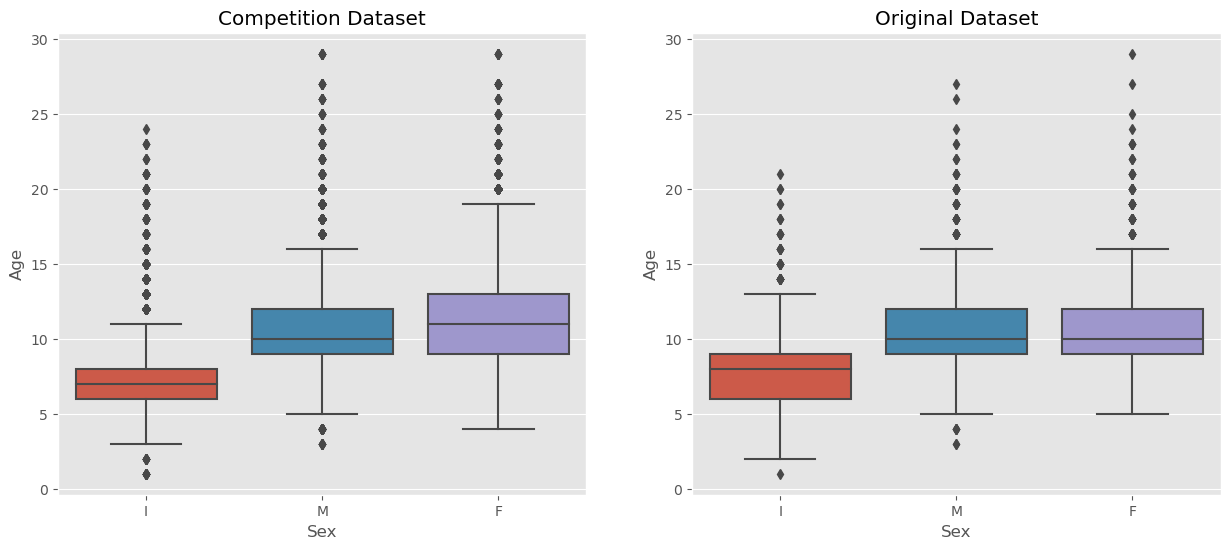

In [16]:
original['Sex'] = pd.Categorical(original['Sex'], categories=['I', 'M', 'F'], ordered=True)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(ax = axes[0], data= train, x= 'Sex', y= 'Age').set_title('Competition Dataset')
sns.boxplot(ax = axes[1], data= original, x= 'Sex', y= 'Age').set_title('Original Dataset')

Text(0.5, 1.0, 'Original Dataset')

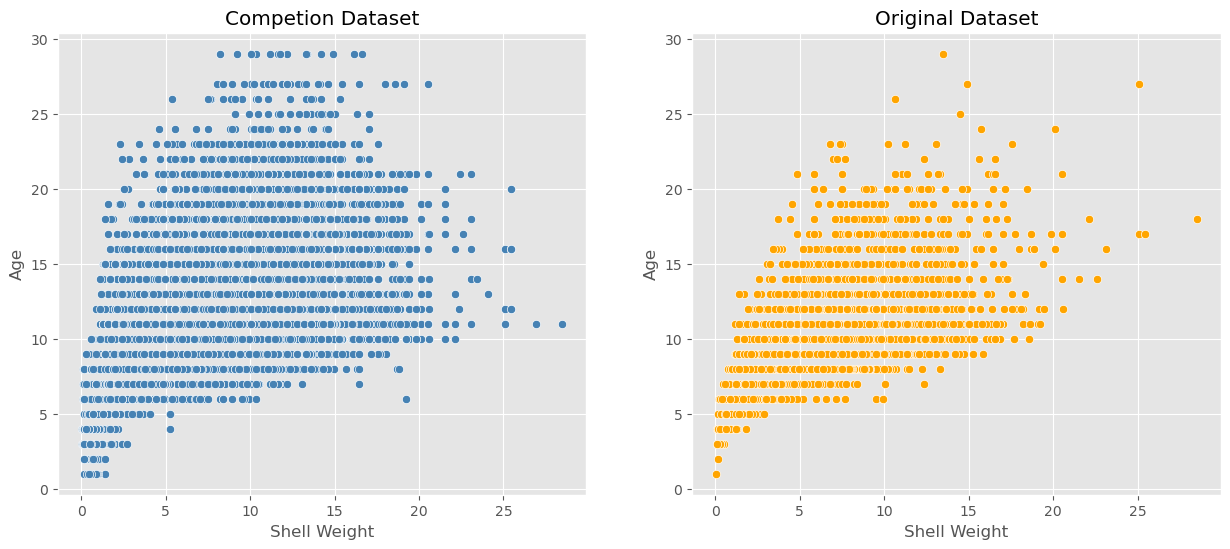

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(ax=axes[0], data=train, x='Shell Weight', y ='Age', color='steelblue').set_title('Competion Dataset')
sns.scatterplot(ax=axes[1], data=original, x='Shell Weight', y ='Age', color='orange').set_title('Original Dataset')

From the above plots, we see that the relationship between `Shell Weight` and `Age` is similar in the comp and original datasets.

Text(0.5, 1.0, 'Original Dataset')

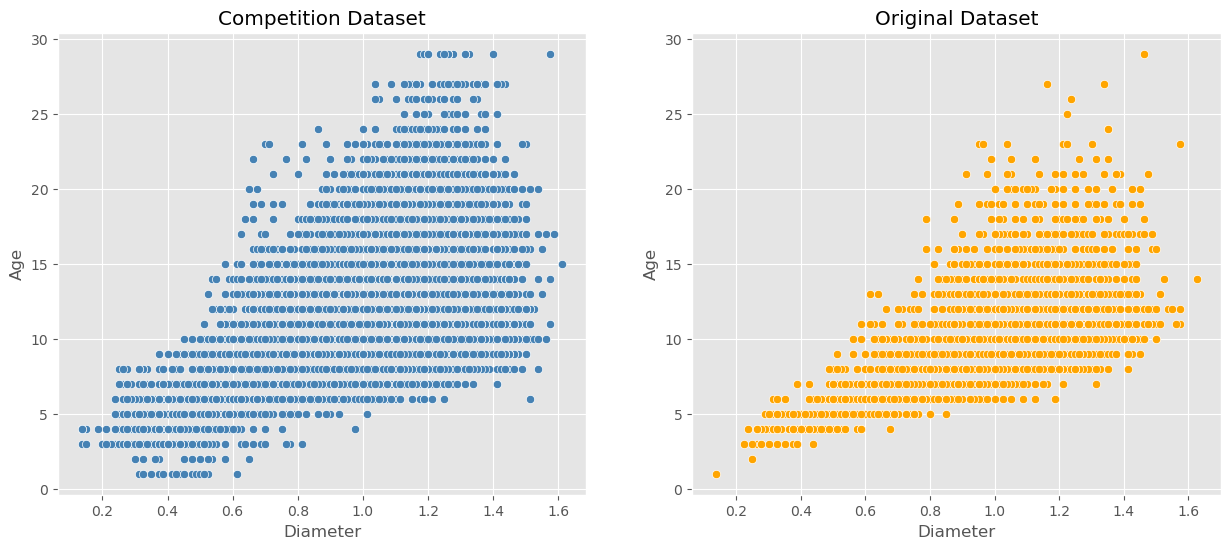

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(ax=axes[0], data=train, x= 'Diameter', y='Age', color='steelblue').set_title('Competition Dataset')
sns.scatterplot(ax=axes[1], data=original, x='Diameter', y ='Age', color ='orange').set_title('Original Dataset')

<a id="6"></a>
# <h1 style="background-color:blue;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

First, we consolidate the `train` and `original` datasets as follows:

In [19]:
le = LabelEncoder()
train['generated'] = 1
original['generated']= 0
test['generated'] = 1

train.drop(columns='id', axis=1, inplace=True)
train = pd.concat([train, original], axis=0).reset_index(drop=True)
train['Sex'] = le.fit_transform(train['Sex'])

In [20]:
train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,generated
0,1,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,1
1,1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,1
2,2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,1
3,0,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1
4,1,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,1


Next we proceed to built a couple of baseline models as show below. Also, we esemble the baseline model predictions using least abosulte deviation regression

In [22]:
X = train.drop(columns=['Age'], axis=1)
y= train['Age']
test_baseline = test.drop(columns=['id'], axis=1)
test_baseline['Sex'] = le.transform(test_baseline['Sex'])

gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

skf = KFold(n_splits=10, random_state=42, shuffle=True)
for i, (train_ix, test_ix) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]


    print('---------------------------------------------------------------')
    
    ######################
    ## GradientBoosting ##
    ######################

    gb_md = GradientBoostingRegressor(loss='absolute_error',
                                      n_estimators=1000,
                                      learning_rate=0.01,
                                      min_samples_split=10,
                                      min_samples_leaf=20).fit(X_train, y_train)
    gb_pred_1 = gb_md.predict(X_test[X_test['generated']==1])
    gb_pred_2 = gb_md.predict(test_baseline)

    gb_score_fold = mean_absolute_error(y_test[X_test['generated'] == 1], gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)
    print('Fold', i, '==> GradientBoosting oof MAE is ==>', gb_score_fold)

---------------------------------------------------------------
